SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

## TOC

### 1. About the dataset
### 2. Download from S3 Blob Storage and Load Cancerdata into a dataframe
### 3. Pre-process the data
### 4. 
### 5. Modeling
### 6. Prediction
### 7. Evaluation
### 8. Visualization

In [47]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn import svm # To model a SVM
from sklearn.metrics import classification_report, confusion_matrix # To evaluate the model
import itertools # To evaluate the model
from sklearn.metrics import f1_score # To obtain the F1-score
from sklearn.metrics import jaccard_similarity_score # To obtain the jaccard index
# The below two statements are to ensure that all print commands in a cell give outputs, not only the last print command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### About the dataset

<h2 id="load_dataset">Load the Cancer data</h2>
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

<br>
<br>

For the purposes of this example, we're using a dataset that has a relatively small number of predictors in each record. To download the data, we will use `!wget` to download it from IBM Object Storage.

In [3]:
#Click here and press Shift+Enter
!wget -O cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv
# We can use curl as
# !curl https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv -o cell_samples.csv

--2020-04-13 21:49:09--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20675 (20K) [text/csv]
Saving to: 'cell_samples.csv'

     0K .......... ..........                                 100%  782K=0.03s

2020-04-13 21:49:09 (782 KB/s) - 'cell_samples.csv' saved [20675/20675]



In [6]:
# Load the downloaded csv data into a pandas dataframe
cell_df = pd.read_csv('cell_samples.csv')
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

In [14]:
# Do some standard data inquiries

cell_df.dtypes # Get the datatypes of all columns
cell_df.shape # get the size of the data, i.e number of rows and number of columns
cell_df.columns # get list of columns
cell_df.head(10) # To eyeball the first ten rows
cell_df.describe() # Get summary statistics
cell_df.corr() # Get the correlation matrix of the data
# Get a heatmap representation of the correlation matrix
cell_df.corr().style.background_gradient(cmap='coolwarm').set_precision(2) # limit number of precision digits after decimal

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

(699, 11)

Index(['ID', 'Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class
ID,1.000000,-0.055308,-0.041603,-0.041576,-0.064878,-0.045528,-0.060051,-0.052072,-0.034901,-0.080226
Clump,-0.055308,1.000000,0.644913,0.654589,0.486356,0.521816,0.558428,0.535835,0.350034,0.716001
UnifSize,-0.041603,0.644913,1.000000,0.906882,0.705582,0.751799,0.755721,0.722865,0.458693,0.817904
UnifShape,-0.041576,0.654589,0.906882,1.000000,0.683079,0.719668,0.735948,0.719446,0.438911,0.818934
MargAdh,-0.064878,0.486356,0.705582,0.683079,1.000000,0.599599,0.666715,0.603352,0.417633,0.696800
SingEpiSize,-0.045528,0.521816,0.751799,0.719668,0.599599,1.000000,0.616102,0.628881,0.479101,0.682785
BlandChrom,-0.060051,0.558428,0.755721,0.735948,0.666715,0.616102,1.000000,0.665878,0.344169,0.756616
NormNucl,-0.052072,0.535835,0.722865,0.719446,0.603352,0.628881,0.665878,1.000000,0.428336,0.712244
Mit,-0.034901,0.350034,0.458693,0.438911,0.417633,0.479101,0.344169,0.428336,1.000000,0.423170
Class,-0.080226,0.716001,0.817904,0.818934,0.696800,0.682785,0.756616,0.712244,0.423170,1.000000


,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class
ID,1.00,-0.06,-0.04,-0.04,-0.06,-0.05,-0.06,-0.05,-0.03,-0.08
Clump,-0.06,1.00,0.64,0.65,0.49,0.52,0.56,0.54,0.35,0.72
UnifSize,-0.04,0.64,1.00,0.91,0.71,0.75,0.76,0.72,0.46,0.82
UnifShape,-0.04,0.65,0.91,1.00,0.68,0.72,0.74,0.72,0.44,0.82
MargAdh,-0.06,0.49,0.71,0.68,1.00,0.60,0.67,0.60,0.42,0.70
SingEpiSize,-0.05,0.52,0.75,0.72,0.60,1.00,0.62,0.63,0.48,0.68
BlandChrom,-0.06,0.56,0.76,0.74,0.67,0.62,1.00,0.67,0.34,0.76
NormNucl,-0.05,0.54,0.72,0.72,0.60,0.63,0.67,1.00,0.43,0.71
Mit,-0.03,0.35,0.46,0.44,0.42,0.48,0.34,0.43,1.00,0.42
Class,-0.08,0.72,0.82,0.82,0.70,0.68,0.76,0.71,0.42,1.00


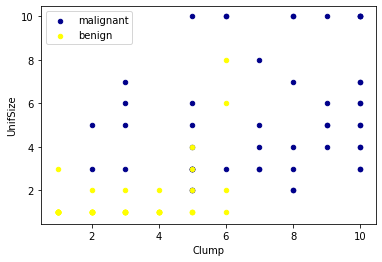

In [11]:
# Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

### Data Preprocessing and Feature Selection

In [13]:
# Examine column datatypes
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [15]:
# Since BareNuc column has some values that are not integers, we can drop rows that do not contain integers

cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [16]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

In [19]:
# Since we want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have 
# one of only two possible values, we need to change its measurement level to reflect this:

cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
# y
# y [0:5]

array([2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 4, 4, 2, 2, 4, 2, 4, 4,
       2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 2,
       4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 2, 4,
       4, 2, 2, 4, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 2, 4,
       4, 4, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 4, 2, 4, 2, 4, 2, 2, 2, 4, 2,
       2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 4, 4, 2, 2, 4, 2, 2,
       4, 4, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 4, 4, 4, 2, 4, 2, 4, 2, 2,
       2, 4, 4, 2, 4, 4, 4, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2,
       2, 4, 4, 2, 2, 2, 4, 4, 2, 4, 4, 4, 2, 2, 4, 2, 2, 4, 4, 4, 4, 2,
       4, 4, 2, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 4, 4, 2,
       2, 4, 2, 4, 4, 4, 2, 2, 2, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 2,
       4, 4, 2, 2, 2, 2, 4, 2, 2, 4, 4, 4, 4, 4, 2, 4, 4, 2, 2, 4, 4, 2,
       2, 4, 4, 2, 4, 2, 4, 4, 2, 2, 4, 2, 2, 2, 4,

In [20]:
# Build Train Test Dataset

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


### Modeling SVM with Scikit-learn

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this exercise.

In [22]:
# from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [30]:
# Use the fitted model to predict

yhat = clf.predict(X_test)
yhat
# yhat [0:5]

array([2, 4, 2, 4, 2, 2, 2, 2, 4, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 4, 2,
       4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4,
       4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 4, 4,
       4, 2, 2, 2, 4, 4, 2, 2, 2, 4, 2, 2, 4, 4, 2, 2, 2, 2, 4, 4, 2, 4,
       2, 2, 4, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 4, 2, 2, 4, 2, 4, 2, 2, 4,
       2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 2, 2, 4, 2, 2, 4, 2, 4, 2,
       2, 2, 2, 2, 4])

In [31]:
# Combine and print the y and yhat(predicted) values in one table for analysis where needed
# Check the object types of y and yhat
type(y_test), type(yhat)
# Covert the np arrays into lists
Y = np.array(y_test).tolist() # Convert y, a numpy array into a list
predY = np.array(yhat).tolist() # Convert yhat, a numpy array into a list
type(Y), type(predY) # Check that the coversions are correctly carried out
len(Y), len(predY) # Check the dimensions of the two lists

(numpy.ndarray, numpy.ndarray)

(list, list)

(137, 137)

In [38]:
# Create a dictionary with the two lists as:
dict = {'y': Y, 'yhat': predY}
# Convert the dictionary into a dataframe
yandyhat = pd.DataFrame(dict)
type(yandyhat), yandyhat.shape, yandyhat.head(10)

# After creating this dataframe, it can be exported to excel or any other file in csv format:
# df.to_excel(r'Path where you want to store the exported excel file\File Name.xlsx', index = False)
# The above statement creates a new sheet in excel and exports the dataframe to excel
# If the dataframe is to be exported to a specific sheet in the excel file:
# df.to_excel(r'Path where you want to store the exported excel file\File Name.xlsx', sheet_name='Your sheet name', index = False)
# Similarly for exporting to a csv file
# df.to_csv(r'Path where you want to store the exported CSV file\File Name.csv', index = False)

(pandas.core.frame.DataFrame,
 (137, 2),
    y  yhat
 0  2     2
 1  4     4
 2  2     2
 3  4     4
 4  2     2
 5  2     2
 6  2     2
 7  2     2
 8  4     4
 9  2     2)

### Evaluation

In [40]:
# Import modules

# from sklearn.metrics import classification_report, confusion_matrix
# import itertools

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137



<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


<Figure size 432x288 with 0 Axes>

Normalized confusion matrix
[[0.94 0.06]
 [0.   1.  ]]


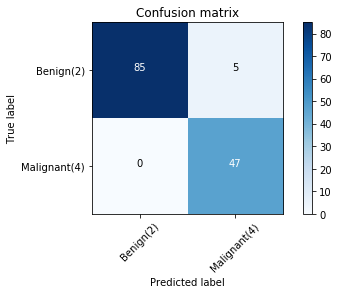

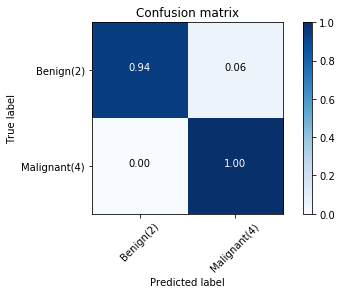

In [44]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= True,  title='Confusion matrix')

In [46]:
# See the F1 score

# from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9639038982104676

In [50]:
# Compute the jaccard index

# from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)
# from sklearn.metrics import jaccard_score
# jaccard_score(y_test, yhat)

0.9635036496350365

### Building the model with a linear kernel

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

array([2, 4, 2, 4, 2, 2, 2, 2, 4, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 4, 2,
       4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4,
       4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 4, 4,
       4, 2, 2, 2, 4, 4, 2, 2, 2, 4, 2, 2, 4, 4, 2, 2, 2, 2, 4, 4, 2, 4,
       2, 2, 4, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 4, 2, 2, 4, 2, 4, 2, 2, 4,
       2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 2, 2, 4, 2, 2, 4, 2, 4, 2,
       2, 2, 2, 2, 4])

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137



<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


<Figure size 432x288 with 0 Axes>

Normalized confusion matrix
[[0.94 0.06]
 [0.   1.  ]]


0.9639038982104676

C:\Users\raman\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.9635036496350365

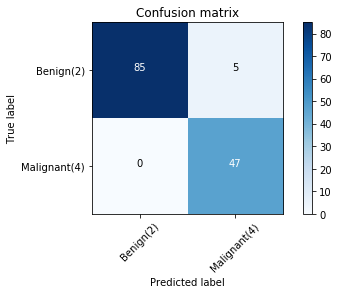

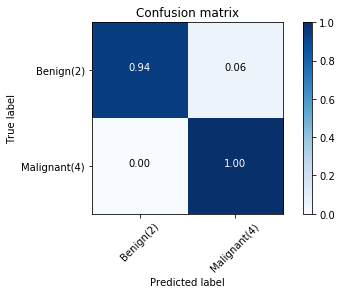

In [54]:
# from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

# Use the fitted model to predict
yhat = clf.predict(X_test)
yhat
# yhat [0:5]

# Evaluate the Model
# First define a confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= True,  title='Confusion matrix')

# See the F1 score
# from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

# Compute the jaccard index
# from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)
# from sklearn.metrics import jaccard_score
# jaccard_score(y_test, yhat)